In [8]:
import sys
sys.path.insert(1, '/Users/linusrandud/Documents/UoM/ERP/MscDissertation/Deep-Opt')

In [9]:
import torch

from COProblems.MKP import MKP
from COProblems.QUBO import QUBO
from Models.DOAE import DOAE
from OptimAE import OptimAEHandler

In [10]:
import wandb
import matplotlib.pyplot as plt

In [11]:
# Initialize device
device = torch.device("cpu")
print(device)

# Define the file path and problem type
file_path = '../data/qubo/bqp100.txt'
problem_type = 'QUBO'
use_wandb = False  # Set to True if using Weights & Biases

cpu


In [13]:
# Parameters
params = {
    'change_tolerance': 100,
    'problem_size': 100,
    'pop_size': 100,
    'dropout_prob': 0.2,
    'l1_coef': 0.0001,
    'l2_coef': 0.0001,
    'learning_rate': 0.002,
    'max_depth': 6,
    'compression_ratio': 0.8
}

# Initialize problem
if problem_type == 'QUBO':
    problem = QUBO(file_path, 0, device)
elif problem_type == 'MKP':
    problem = MKP(file_path, params['fitness_file'], params['num_constraints'], device)
else:
    raise ValueError("Unsupported problem type")

if use_wandb:
    import wandb
    wandb.init(project="Deep Optimization", tags=[problem_type])
    wandb.log_artifact(file_path, type='dataset')

# Unpack parameters
change_tolerance = params['change_tolerance']
problem_size = params['problem_size']
pop_size = params['pop_size']
dropout_prob = params['dropout_prob']
l1_coef = params['l1_coef']
l2_coef = params['l2_coef']
lr = params['learning_rate']
max_depth = params['max_depth']
compression_ratio = params['compression_ratio']
hidden_size = problem_size

# Initialize model and handler
model = DOAE(problem_size, dropout_prob, device)
handler = OptimAEHandler(model, problem, device)

if use_wandb:
    wandb.config.update({
        "change_tolerance": change_tolerance,
        "problem_size": problem_size,
        "pop_size": pop_size,
        "dropout_prob": dropout_prob,
        "l1_coef": l1_coef,
        "l2_coef": l2_coef,
        "learning_rate": lr,
        "compression_ratio": compression_ratio,
        "max_depth": max_depth,
    })
    wandb.watch(model, log='all')

# Generate initial population
population, fitnesses = handler.generate_population(pop_size)
population, fitnesses, _, _ = handler.hillclimb(population, fitnesses, change_tolerance)
handler.print_statistics(fitnesses)

total_eval = 0
depth = 0

# Store metrics for custom plotting
mean_fitnesses = []
max_fitnesses = []
total_evaluations = []

while True:
    if depth < max_depth:
        print("Adding layer")
        hidden_size = round(hidden_size * compression_ratio)
        model.transition(hidden_size)
        depth += 1
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)
    
    print("Learning from population")
    handler.learn_from_population(population, optimizer, l1_coef=l1_coef, batch_size=pop_size)
    
    print("Optimising population")
    population, fitnesses, evaluations, done = handler.optimise_solutions(
        population, fitnesses, change_tolerance, encode=True, repair_solutions=True, deepest_only=False
    )
    handler.print_statistics(fitnesses)

    mean_fitness = fitnesses.mean().item()
    max_fitness = fitnesses.max().item()
    total_eval += evaluations

    mean_fitnesses.append(mean_fitness)
    max_fitnesses.append(max_fitness)
    total_evaluations.append(total_eval)

    if use_wandb:
        wandb.log({
            "mean_fitness": mean_fitness,
            "max_fitness": max_fitness,
            "total_eval": total_eval,
            "depth": depth
        })

    print(f"Evaluations: {total_eval}")
    
    if done:
        break

Instance has been loaded
Max pop fitness: 7822.0, Mean pop fitness : 7199.27978515625
Adding layer
Learning from population
Optimising population
Max pop fitness: 7970.0, Mean pop fitness : 7602.580078125
Evaluations: 19184
Adding layer
Learning from population
Optimising population
Max pop fitness: 7970.0, Mean pop fitness : 7756.330078125
Evaluations: 44893
Adding layer
Learning from population
Optimising population
Max pop fitness: 7970.0, Mean pop fitness : 7823.6298828125
Evaluations: 78397
Adding layer
Learning from population
Optimising population
Max pop fitness: 7970.0, Mean pop fitness : 7865.18994140625
Evaluations: 120366
Adding layer
Learning from population
Optimising population
Max pop fitness: 7970.0, Mean pop fitness : 7873.3701171875
Evaluations: 171084
Adding layer
Learning from population
Optimising population
Max pop fitness: 7970.0, Mean pop fitness : 7878.490234375
Evaluations: 231864
Learning from population
Optimising population
Max pop fitness: 7970.0, Mean po

KeyboardInterrupt: 

In [16]:
population[0]

tensor([-1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
        -1.,  1., -1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1., -1.,
        -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
         1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,
         1., -1., -1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,
        -1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,
        -1.,  1.])

In [15]:
fitnesses

tensor([7970., 7970., 7766., 7970., 7970., 7868., 7778., 7970., 7964., 7826.,
        7970., 7970., 7970., 7970., 7970., 7970., 7970., 7970., 7970., 7970.,
        7432., 7970., 7970., 7826., 7970., 7970., 7908., 7970., 7970., 7624.,
        7970., 7970., 7970., 7848., 7970., 7739., 7898., 7970., 7764., 7970.,
        7970., 7970., 7964., 7970., 7970., 7970., 7614., 7970., 7628., 7970.,
        7970., 7970., 7970., 7970., 7850., 7898., 7722., 7970., 7970., 7970.,
        7970., 7970., 7830., 7970., 7970., 7970., 7970., 7694., 7486., 7668.,
        7970., 7970., 7970., 7970., 7970., 7805., 7970., 7970., 7970., 7786.,
        7970., 7970., 7885., 7970., 7970., 7970., 7970., 7574., 7970., 7970.,
        7970., 7970., 7970., 7800., 7970., 7892., 7644., 7970., 7492., 7970.])

depth,▁▅██████████████████████████████████████
max_fitness,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_fitness,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_eval,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
depth,6
max_fitness,0.0
mean_fitness,0.0
total_eval,1605907


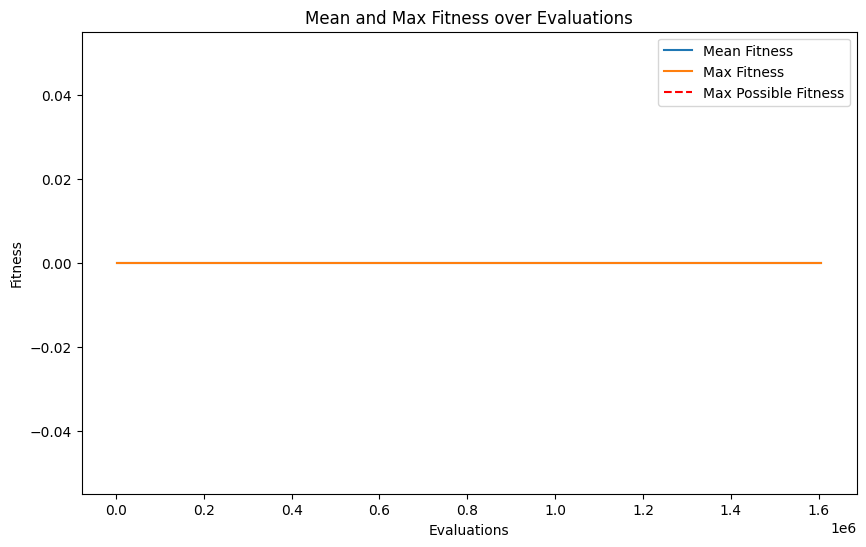

In [7]:
# Custom plot
plt.figure(figsize=(10, 6))
plt.plot(total_evaluations, mean_fitnesses, label='Mean Fitness')
plt.plot(total_evaluations, max_fitnesses, label='Max Fitness')
plt.axhline(y=problem.max_fitness, color='r', linestyle='--', label='Max Possible Fitness')
plt.xlabel('Evaluations')
plt.ylabel('Fitness')
plt.title('Mean and Max Fitness over Evaluations')
plt.legend()

# Save plot to W&B
wandb.log({"fitness_plot": wandb.Image(plt)})

# Finish the W&B run
wandb.finish()

In [34]:
import torch

from COProblems.MKP import MKP
from COProblems.QUBO import QUBO
from Models.DOAE import DOAE
from OptimAE import OptimAEHandler

# Highly recommended to keep as cpu for problems of size <= 100
# device = "cuda" if torch.cuda.is_available() else "cpu"
# device="cpu"
# print(device)
# device = torch.device(device)

change_tolerance = 100
problem_size = 20
pop_size = 20
# problem = MKP("COProblems\\mkp\\problems30d.txt", "COProblems\\mkp\\fitnesses30d.txt", 12, device)
#problem = QUBO("COProblems\\qubo\\bqp500.txt", 0, device)

dropout_prob = 0.2
# 1000 bit QUBO l1 and l2:
# l1_coef = 0.0000025
# l2_coef = 0.0000025
# 500 bit QUBO l1 and l2:
# l1_coef = 0.000005
# l2_coef = 0.000005
# 100 bit l1 and l2
l1_coef = 0.0001
l2_coef = 0.0001
lr = 0.002
max_depth = 6
compression_ratio = 0.8
model = DOAE(problem_size, dropout_prob, device)
hidden_size = problem_size
handler = OptimAEHandler(model, problem, device)

# # Log hyperparameters
# wandb.config.update({
#     "change_tolerance": change_tolerance,
#     "problem_size": problem_size,
#     "pop_size": pop_size,
#     "dropout_prob": dropout_prob,
#     "l1_coef": l1_coef,
#     "l2_coef": l2_coef,
#     "learning_rate": lr,
#     "compression_ratio": compression_ratio,
#     "max_depth": max_depth,
# })

# # Log model architecture
# wandb.watch(model, log='all')

population, fitnesses = handler.generate_population(pop_size)
population, fitnesses, _, _ = handler.hillclimb(population, fitnesses, change_tolerance)
handler.print_statistics(fitnesses)

total_eval = 0
depth = 0

# Store metrics for custom plotting
mean_fitnesses = []
max_fitnesses = []
total_evaluations = []

while True:
    if depth < max_depth:
        print("Adding layer")
        hidden_size = round(hidden_size * compression_ratio)
        model.transition(hidden_size)
        depth += 1
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)
    print("Learning from population")
    # Learning with the entire population as a batch is technically not the best from a machine learning perspective,
    # but does not seem to have a massive impact on solution quality whilst also increasing learning speed significantly.
    handler.learn_from_population(population, optimizer, l1_coef=l1_coef, batch_size=pop_size)
    print("Optimising population")
    population, fitnesses, evaluations, done = handler.optimise_solutions(
        population, fitnesses, change_tolerance, encode=True, repair_solutions=True, deepest_only=False
    )
    handler.print_statistics(fitnesses)
    
    # Log metrics to W&B
    mean_fitness = fitnesses.mean().item()
    max_fitness = fitnesses.max().item()
    total_eval += evaluations

    mean_fitnesses.append(mean_fitness)
    max_fitnesses.append(max_fitness)
    total_evaluations.append(total_eval)

    # wandb.log({
    #     "mean_fitness": mean_fitness,
    #     "max_fitness": max_fitness,
    #     "total_eval": total_eval,
    #     "depth": depth
    # })
    
    print("Evaluations: {}".format(total_eval))
    
    # Uncomment lines below to print out best solution at every transition
    # best_i = torch.argmax(fitnesses)
    # print("Best solution - fitness = {}".format(fitnesses[best_i].item()))
    # print(population[best_i].tolist())
    if done:
        break

Max pop fitness: 0.0, Mean pop fitness : 0.0
Adding layer
Learning from population
Optimising population
Max pop fitness: 0.0, Mean pop fitness : 0.0
Evaluations: 2020
Adding layer
Learning from population
Optimising population
Max pop fitness: 0.0, Mean pop fitness : 0.0
Evaluations: 6060
Adding layer
Learning from population
Optimising population
Max pop fitness: 0.0, Mean pop fitness : 0.0
Evaluations: 12120
Adding layer
Learning from population
Optimising population
Max pop fitness: 0.0, Mean pop fitness : 0.0
Evaluations: 20200
Adding layer
Learning from population
Optimising population
Max pop fitness: 0.0, Mean pop fitness : 0.0
Evaluations: 30300
Adding layer
Learning from population
Optimising population
Max pop fitness: 0.0, Mean pop fitness : 0.0
Evaluations: 42420
Learning from population
Optimising population
Max pop fitness: 0.0, Mean pop fitness : 0.0
Evaluations: 54540
Learning from population
Optimising population
Max pop fitness: 0.0, Mean pop fitness : 0.0
Evaluation

KeyboardInterrupt: 

In [35]:
model

DOAE(
  (encoder): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=20, out_features=16, bias=True)
    (2): Tanh()
    (3): Linear(in_features=16, out_features=13, bias=True)
    (4): Tanh()
    (5): Linear(in_features=13, out_features=10, bias=True)
    (6): Tanh()
    (7): Linear(in_features=10, out_features=8, bias=True)
    (8): Tanh()
    (9): Linear(in_features=8, out_features=6, bias=True)
    (10): Tanh()
    (11): Linear(in_features=6, out_features=5, bias=True)
    (12): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=6, bias=True)
    (1): Tanh()
    (2): Linear(in_features=6, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=13, bias=True)
    (7): Tanh()
    (8): Linear(in_features=13, out_features=16, bias=True)
    (9): Tanh()
    (10): Linear(in_features=16, out_features=20, bias=True)
    (11): T

In [36]:
population[0]

tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.])

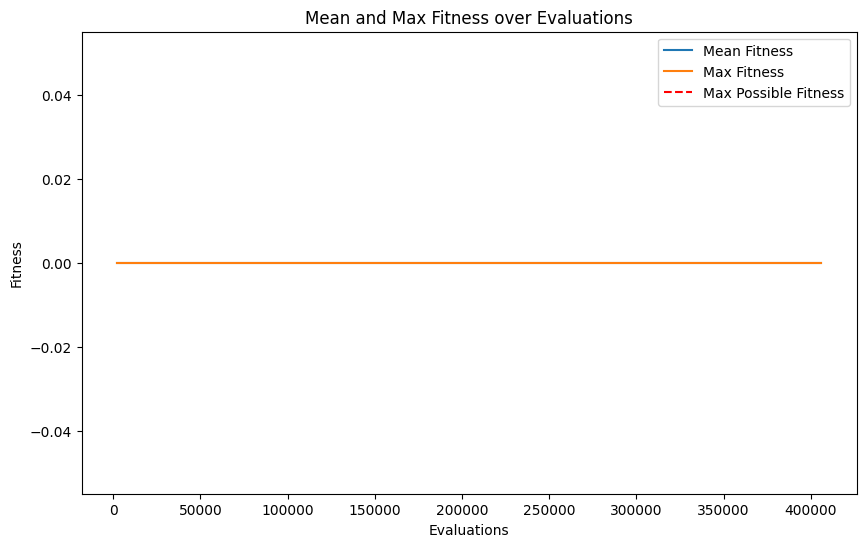

In [38]:
# Custom plot
plt.figure(figsize=(10, 6))
plt.plot(total_evaluations, mean_fitnesses, label='Mean Fitness')
plt.plot(total_evaluations, max_fitnesses, label='Max Fitness')
plt.axhline(y=problem.max_fitness, color='r', linestyle='--', label='Max Possible Fitness')
plt.xlabel('Evaluations')
plt.ylabel('Fitness')
plt.title('Mean and Max Fitness over Evaluations')
plt.legend()

# # Save plot to W&B
# wandb.log({"fitness_plot": wandb.Image(plt)})

# # Finish the W&B run
# wandb.finish()

In [ ]:
model

DOAE(
  (encoder): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=100, out_features=80, bias=True)
    (2): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=80, out_features=100, bias=True)
    (1): Tanh()
  )
)

In [ ]:
fitnesses

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [ ]:
population

tensor([[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-